In [1]:
% ignore - internal setup
path('windfarm', path)
set(0, 'DefaultLineLineWidth', 2)
set(0, 'DefaultAxesFontSize', 14);

# Robust Wind Farm Layout Optimization

In this problem we want to find the optimal turbine layout for a wind farm in order to minimize cost of energy (COE).  We will consider a very simplified wind farm with only three wind turbines. The first turbine will be fixed at (0, 0) and the x-positions of the back two turbines will be fixed with 4 diameter spacing between them.  The only thing we can change is the y position of the two back turbines as shown in the figure below (all dimensions in this problem are in terms of rotor diameters).  In other words, we just have two design variables: $y_2$ and $y_3$.

<img src="windfarm/wakes.pdf" style="width: 400px;"/>

We further simplify by assuming the wind always comes from the west as shown in the figure above, and is always at a constant speed.  The wake model has a few parameters that define things like its spread angle and decay rate.  We will refer to this parameters as $\alpha$, $\beta$ and $\delta$ (knowing exactly what each parameter corresponds to is not important for our purposes).  The code below computes the cost of energy (COE) of the wind farm$^*$ as a function of the inputs including the positions of the back turbines: `yback` = [$y_2$, $y_3$], as well as the three wake parameters $\alpha$, $\beta$ and $\delta$.  There is also an optional parameter plotit that defaults to false.  You'll want to keep it false while running optimizations, but if you want to visualize the results after an optimization you can set it to true.  Copy/paste the code below and put it in a file called farmcost.m.  You won't need to change any of it.

$^*$Note that the function is highly simplified and does not really compute cost of energy, just something representative for this problem.  

In [ ]:
function coe = farmcost(yback, alpha, beta, delta, plotit)

    if nargin == 4
        plotit = false;
    end

    x = [0.0, 4.0, 8.0];
    y = [0, yback];  % append 0 in front for lead turbine
    CP = [0.38, 0.38, 0.38];
    rho = 1.2;
    
    u12 = jensenwake(x(2)-x(1), y(2)-y(1), alpha, beta, delta);
    u13 = jensenwake(x(3)-x(1), y(3)-y(1), alpha, beta, delta);
    u23 = jensenwake(x(3)-x(2), y(3)-y(2), alpha, beta, delta);

    u = zeros(3, 1);
    u(1) = 1.0;
    u(2) = u12;
    u(3) = 1 - sqrt((1-u13)^2 + (1-u23)^2);
    
    P = zeros(3, 1);
    for i = 1:3
        P(i) = CP(i)*0.5*rho*u(i)^3*pi*1.0^2/4;
    end
    
    area = mean((x - mean(x)).^2 + (y - mean(y)).^2);
    othercost = 1.0;

    power = sum(P);
    
    coe = (area/100 + othercost)/power;
    
    if plotit
        
        nx = 200;
        ny = 250;
        
        xvec = linspace(-2, 12, nx);
        yvec = linspace(-5, 10, ny);

        [X, Y] = ndgrid(xvec, yvec);
        U1 = zeros(nx, ny);
        U2 = zeros(nx, ny);
        U3 = zeros(nx, ny);

        for i = 1:nx
            for j = 1:ny
                U1(i, j) = jensenwake(X(i, j)-x(1), Y(i, j)-y(1), alpha, beta, delta);
                U2(i, j) = jensenwake(X(i, j)-x(2), Y(i, j)-y(2), alpha, beta, delta);
                U3(i, j) = jensenwake(X(i, j)-x(3), Y(i, j)-y(3), alpha, beta, delta);
            end
        end


        Udef = 1 - sqrt((1-U1).^2 + (1-U2).^2 + (1-U3).^2);

        figure;
        contourf(X, Y, Udef, 200, 'LineStyle', 'none');
        colorbar;
        xlabel('x/D');
        ylabel('y/D');
    end

end


function V = jensenwake(x, y, alpha, beta, delta)

    % x and y normalized by D
    if x < 0
        V = 1;
        return
    end

    theta = atan(y/(x + delta));  
    f = 0.0;
    if abs(theta) < pi/beta
        f = 0.5*(1 + cos(beta*theta));
    end

   % normalized by Uinf
    V = 1 - 2/3*(0.5/(0.5 + alpha*x))^2*f;
end


The following is an example of using the visualization.  We are going to use the wake parameters
$$
\alpha = 0.1\\
\beta = 9\\
\delta = 5
$$
with $y_2 = 2$ and $y_3 = 5$.  This means that the center of turbine 2 is 2 rotor diameters up from the center line, and turbine 3 is 5 diameters up from the centerline.   I've turned on plotting so we can visualize the results.

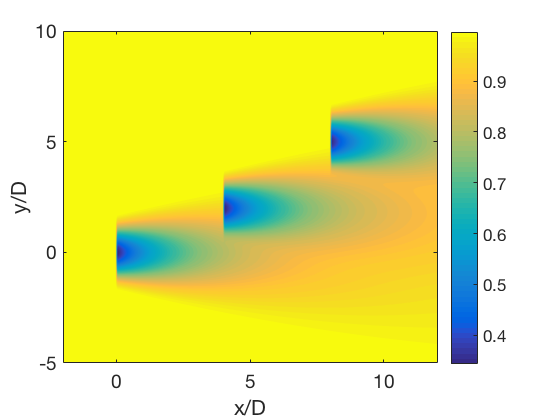

In [7]:
alpha = 0.1;
beta = 9;
delta = 5;

yback = [2 5];

farmcost(yback, alpha, beta, delta, true);

The contours show the magnitude of the velocity in the direction of the wind (normalized by the velocity of the wind).  Most places it is at a value of 1.0, meaning full wind speed.  Just behind each turbine there is a wake where the velocity drops. If other turbines are in this wake then they will produce less power.  that suggests that we should spread the  turbines far apart.  However, the further we move the turbines the more land we need and that affects our costs.  The optimization seeks to find a good balance by minimizing the total cost of energy (including power production and land-use costs).

## Deterministic Optimization

The first task is to run the optimization deterministically.  In other words we will assume that the three wake parameters are deterministic:
$$
\alpha = 0.1\\
\beta = 9\\
\delta = 5
$$
Because there are several possible similar solutions we will add the following constraints:
$$ 
y_i > 0 \text{ (bound)}\\
y_3 > y_2 \text{ (linear)}
$$
You should not use [0, 0] as the starting point for your optimization, as that occurs right at a flat spot in the wake (a fixed point) and so you may not make any progress in the optimization.  Report the optimal spacing that you find.  A template is provided below to get you started.

In [ ]:
% deterministic values
alpha = 0.1;
beta = 9;
delta = 5;

% starting point and bounds
y0 = 
lb = [0 0];
ub = [10 10];

% linear constraint
% TODO: the constraint y3 > y2 can be formulated as a linear constraint.

% objective
obj = @(x) farmcost(x, alpha, beta, delta);

% options
% TODO: set any options that you want.

% deterministic optimization
[ystar, fstar] = fmincon(obj, y0, A, b, [], [], lb, ub, [], options);

## Statistical Convergence

We now consider the more realistic scenario where the wake parameters are not deterministic, but are rather uncertain variables governed by some probability distribution.  Specifically we have the following information for the three parameters:
- $\alpha$ is governed by a [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution) distribution with a scale parameter of 0.1, and a shape parameter of 1 (this choice of parameters has a mean of 0.1, to correspond to our deterministic value of $\alpha = 0.1$ used before).
- $\beta$ is given by a Normal distribution with a mean and standard deviation of $\mu = 9$, $\sigma=1$
- $\delta$ is given by a  Normal distribution with a mean and standard deviation of $\mu = 5$, $\sigma=0.4$

Note that the mean for all of these distributions corresponds to the determinsitic value we used previously.  In other words, the deterministic optimization could be thought of as using the mean value for each of these distributions.



In [8]:
% statistical parameters
ascale = 0.1;
ashape = 1.0;
bmean = 9;
bsd = 1;
dmean = 5;
dsd = 0.4;

I will plot each of these probability distributions.  You don't need to do this, I just do it to help you visualize what is happening.  (for some reason this notebook displays the graphs in  reverse order from how they are generated in the code).

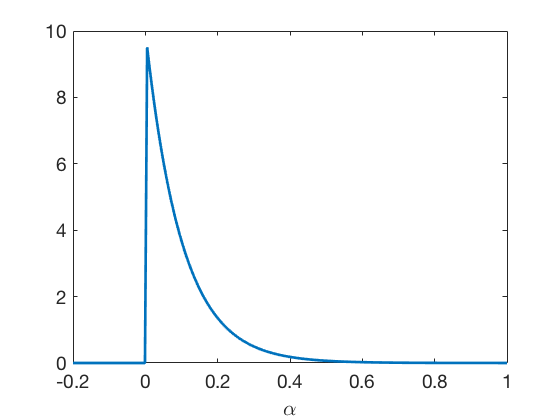

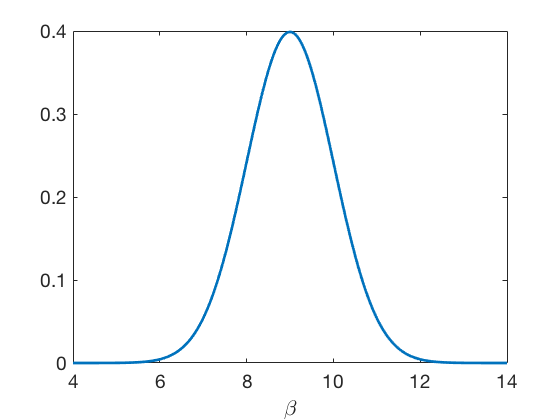

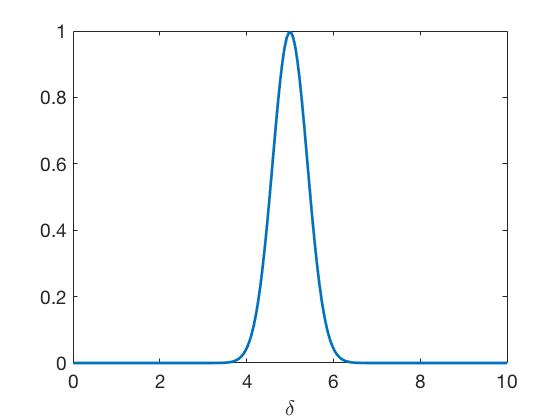

In [32]:
pd = makedist('Normal', dmean, dsd);
x = linspace(0, 10, 200);
y = pdf(pd,x);

figure;
plot(x, y);
xlabel('\delta')

pd = makedist('Normal', bmean, bsd);
x = linspace(4, 14, 200);
y = pdf(pd,x);

figure;
plot(x, y);
xlabel('\beta')

pd = makedist('Weibull', ascale, ashape);
x = linspace(-.2, 1, 200);
y = pdf(pd,x);

figure;
plot(x, y);
xlabel('\alpha')

We will use Monte Carlo simulations to propagate the uncertainty.  This is not an efficient method, but it is simple and will be sufficient for developing the understanding needed in this assignment.  Basically, you randomly sample from these input distributions, run the analysis a bunch of times, then draw statistics from the output distributions.  
To generate the random numbers from the input distributions, using Latin Hypercube sampling may be more efficient (but is not required).  If you don't use LHS, then you'll want to use the functions [wblrnd](https://www.mathworks.com/help/stats/wblrnd.html), and [randn](https://www.mathworks.com/help/matlab/ref/randn.html).  If you do use LHS, then you will want to use the [lhsdesign](https://www.mathworks.com/help/stats/lhsdesign.html) function and the [icdf](https://www.mathworks.com/help/stats/icdf.html) function.   [This example](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube) in Python might also be helpful (in this example the ppf function is the same as icdf, the inverse cumulative distribution function).

The problem is that we don't know how many samples to run in order to have reasonably converged output  statistics.  To figure that out we'll have to repeat the Monte Carlo simulation for a bunch of different sizes and look to see when things start converging.

A template is below.

In [ ]:
% try increasing large samples
nvec = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600];

% initialize the array of results from each sample size
cost = zeros(size(nvec));

for i = 1:length(nvec)  % repeat Monte Carlo for many different sample sizes
    n = nvec(i);

    % TODO: generate random numbers from the input distributions.
    
    % initialize for Monte Carlo
    costvec = zeros(n, 1);
    
    for j = 1:n  % loop over all of the trials
        costvec(j) = farmcost(yback, randa(j), randb(j), randd(j));
    end
    
    % TODO: compute some statistic using costvec (e.g., mean, prctile, etc.)
    cost(i) = 
end

figure;
semilogx(nvec, cost, 'o');

Determine a reasonable number of samples to produce a converged value for the a quantity of interest (e.g., mean, variance, etc.).  You might try more than one metric.  Because of randomness you won't have perfect convergence and you'll want to rerun several times.  As an example, you might consider the statistic as converged, if it doesn't deviate by more than about 0.5% from a highly converged value (a case run with a high number of samples), with some added conservatism.  The results will vary somewhat depending on the design variables you are using.  You might try multiple points, or it would be reasonable to use the optimal design variables from the deterministic case, since you expect the optimization under uncertainty result to be not too far away.  Report the number of samples you used, and include a converge plot.

Once you select a reasonable value for n, we could plot the output distribution using

In [ ]:
figure;
histogram(costvec);

A typical histogram (always slightly different because of randomness), for the cost of energy will like that shown below:

<img src="windfarm/histogram.pdf" style="width: 400px;"/>

We need to decide what objective we will use in our optimization.  A common objective might be to minimize the mean value of this probability density function.  In our case, we will try something else because of the long tail to the right.  Instead of minimizing the mean, we are going to minimize the 95th percentile.  You could think of this as something like minimizing a worst-case scenario.  In other words, 95% of the time we will have a COE less than the 95th percentile.  The [prctile](https://www.mathworks.com/help/stats/prctile.html) function will be useful for this purpose.  In general, you'd want to rerun your convergence analysis using prctile as your metric, but for our purposes you don't need to rerun unless you want to.

## Robust Optimum

With an understanding of how many samples are required to obtain reasonably converged statistics, run an optimization under uncertainty to minimize the 95th percentile COE.  You'll want to create an objective function that runs the Monte Carlo simulation and returns the 95th percentile COE.  You should compute the random sampling points for your Monte Carlo simulation once prior to the optimization, and **not change them during the optimization**.  If you recompute the random variables during the optimization, your gradients will be unusable.



In [ ]:
function [cost] = ouufarmcost(yback, randa, randb, randd)

    % TODO: return the 95th percentile of the COE by performing a
    % Monte Carlo simulation using the random numbers contained in randa, randb, randd 

end

In [ ]:
% define objective function
randa = % generate random numbers from Weibull using the n you found from convergence study
randb = % similarly for beta and delta
randd = 

obj = @(x) ouufarmcost(x, randa, randb, randd);

% deterministic optimization
% note that I am starting at the deterministic optimum for efficiency
[ystarOUU, fstarOUU] = fmincon(obj, ystar, A, b, [], [], lb, ub, [], options);  

Compare the optimal positions to the deterministic case.  Do the differences make sense to you?  

Once you have completed both optimizations, you should perform a cross analysis by filling out the table below.  You take the 2 optimal designs that you found, and you compare each on the 2 objectives (determinisitc, and 95th percentile).  You should produce 4 numbers.  The first row corresponds to the performance of the optimal deterministic layout.  Evaluate the performance of this layout using the deterministic value for COE, and the 95th percentile that accounts for uncertainty.  Repeat for the optimal solution for the OUU case.  

|   | Deterministic COE  |  95th percentile COE |
|---|---|---|
| Deterministic Layout  |   |   | 
| OUU Layout  |   |   |  |


The numbers that we care about the most are in the right column.  The real wind farm is going to have uncertainty.  If we ignore that uncertainty and optimize using deterministic values we can expect to have a performance like that shown in the upper right quadrant.  However, if we account for that uncertainty upfront in our optimization we can do better.  (For this problem you should see about a 5% decrease in the 95th percentile COE). 
